<table width="100%" border="3">
  <tbody>
    <tr>
      <td width=120><img src="https://is4-ssl.mzstatic.com/image/thumb/Purple128/v4/9f/38/cb/9f38cb51-c606-6fd4-54b3-47bfdb06b712/source/256x256bb.jpg" alt="Aidea" width="120"/></td>
      <td align='left'><h1>TensorFlow 2 Object Detection</h1><BR><h2>D3-MBSH Baseline Solution</h2></td>
    </tr>
  </tbody>
</table>

# Baseline Solution for Mosquito Breeding Site Hunting for Dengue Fever Control

__IEEE ICIP 2019 Grand Challenge__ https://aidea-web.tw/icip



## Step 1: 設定雲端硬碟

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


## Step 5: 安裝套件

In [ ]:
!pip install tf_slim
!pip install lvis
!pip install tensorflow-addons

     |████████████████████████████████| 358kB 7.3MB/s 
     |████████████████████████████████| 686kB 7.6MB/s 


## Step 6: 設定工作環境

In [ ]:
%env PYTHONPATH=/env/python:/content/drive/My Drive/models:/content/drive/My Drive/models/research:/content/drive/My Drive/models/research/slim

env: PYTHONPATH=/env/python:/content/drive/My Drive/models:/content/drive/My Drive/models/research:/content/drive/My Drive/models/research/slim


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/models')

In [ ]:
from os import chdir
chdir("/content/drive/My Drive/models/research/")

## Step 7: 測試Object Detection套件

In [ ]:
!python object_detection/builders/model_builder_tf2_test.py

2021-06-17 02:49:31.388342: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2021-06-17 02:50:23.005426: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-17 02:50:23.068607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-17 02:50:23.069186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-06-17 02:50:23.069221: I tensorflow/stream_executor/platform/default/dso_loader.cc:5

# Part 2: 設定模型和測試

## Step 1: 從老師的雲端硬碟下載模型或用自己訓練的模型

https://drive.google.com/file/d/1Ihqblvz8oCHuHy3hLF9LqeD-mYdPvsGK/view?usp=sharing

https://drive.google.com/file/d/1wv7lNLdYsOADZvCkCH6jzvHYdX9v3FdQ/view?usp=sharing

In [ ]:
!gdown --id 1Ihqblvz8oCHuHy3hLF9LqeD-mYdPvsGK

In [ ]:
!gdown --id 1wv7lNLdYsOADZvCkCH6jzvHYdX9v3FdQ

Downloading...
From: https://drive.google.com/uc?id=1wv7lNLdYsOADZvCkCH6jzvHYdX9v3FdQ
To: /content/drive/My Drive/models/research/efficientdet_d0_mbsh.zip
57.6MB [00:01, 56.7MB/s]


In [ ]:
!unzip efficientdet_d0_mbsh.zip

Archive:  efficientdet_d0_mbsh.zip
replace efficientdet_d0_mbsh/checkpoint/ckpt-101.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: efficientdet_d0_mbsh/checkpoint/ckpt-101.data-00000-of-00001  
  inflating: efficientdet_d0_mbsh/checkpoint/ckpt-101.index  
  inflating: efficientdet_d0_mbsh/checkpoint/ckpt-301.data-00000-of-00001  
  inflating: efficientdet_d0_mbsh/checkpoint/ckpt-301.index  
  inflating: efficientdet_d0_mbsh/mbsh_label_map.pbtxt  
  inflating: efficientdet_d0_mbsh/mbsh_pipeline.config  


In [ ]:
!ls efficientdet_d0_mbsh/checkpoint

ckpt-101.data-00000-of-00001  ckpt-301.data-00000-of-00001
ckpt-101.index		      ckpt-301.index


## Step 2: 設定執行環境所需的函數庫

In [ ]:
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt

import io
import os
import pathlib
import random
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
def load_image_into_numpy_array(path):
  #Load an image from file into a numpy array.
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  image = image.convert("RGB")
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def get_keypoint_tuples(eval_config):
  """Return a tuple list of keypoint edges from the eval config.
  
  Args:
    eval_config: an eval config containing the keypoint edges
  
  Returns:
    a list of edge tuples, each in the format (start, end)
  """
  tuple_list = []
  kp_list = eval_config.keypoint_edge
  for edge in kp_list:
    tuple_list.append((edge.start, edge.end))
  return tuple_list

## Step 3: 設定模型

In [ ]:
import os
pipeline_path = 'efficientdet_d0_mbsh/mbsh_pipeline.config'
model_dir = 'efficientdet_d0_mbsh/checkpoint'
configs = config_util.get_configs_from_pipeline_file(pipeline_path)

In [ ]:
def get_model_detection_function(model):
  """Get a tf.function for detection."""
  @tf.function
  def detect_fn(image):
    """Detect objects in image."""
    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)
    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

In [ ]:
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)
detect_fn = get_model_detection_function(detection_model)

In [ ]:
# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-301')).expect_partial()

In [ ]:
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=False)

In [ ]:
## Step 3: 用訓練的模型預測測試集的物件

In [ ]:
import numpy as np
from PIL import Image
from IPython.display import display

2008121430.jpg


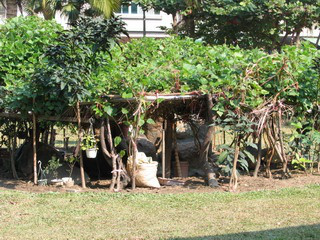

In [ ]:
image_dir = 'data/test_cdc/test_images/'
image_name = random.choice(os.listdir(image_dir))
print(image_name)
image_path = image_dir + image_name
test_image = Image.open(image_path)
display(test_image)

In [ ]:
image_np = load_image_into_numpy_array(image_path)
input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
width  = image_np.shape[1]
height = image_np.shape[0]
print(f"{width}x{height}")

320x240


In [ ]:
detections, predictions_dict, shapes = detect_fn(input_tensor)
print(detections["detection_scores"])

tf.Tensor(
[[0.8453393  0.40895718 0.18692024 0.08075969 0.06823359 0.06149824
  0.06087445 0.0594839  0.05784683 0.04805391 0.04308032 0.03656835
  0.03646629 0.03552737 0.0345668  0.03437315 0.03242233 0.03082038
  0.03072632 0.02958738 0.02750554 0.02688945 0.02681629 0.02660191
  0.02617775 0.02601012 0.02570321 0.02564299 0.02534856 0.02500339
  0.02426264 0.0241943  0.02351779 0.02326271 0.02225725 0.0218719
  0.0210183  0.02088818 0.02078463 0.02052726 0.02049292 0.02043261
  0.02027693 0.02020967 0.02001273 0.01995233 0.0199302  0.01950373
  0.01879105 0.01879053 0.018696   0.01867357 0.01859667 0.01854913
  0.01844644 0.01841289 0.01790961 0.01782679 0.01759361 0.01742229
  0.01715149 0.01704802 0.01699287 0.01683483 0.01680494 0.01676185
  0.01667956 0.01656171 0.01645541 0.01642572 0.01641372 0.01632037
  0.01627143 0.01588122 0.01582476 0.01581478 0.01568809 0.01560414
  0.01546373 0.01531934 0.01531835 0.01523743 0.01516152 0.01515787
  0.01505286 0.01468422 0.01465904 0.0

In [ ]:
number=3

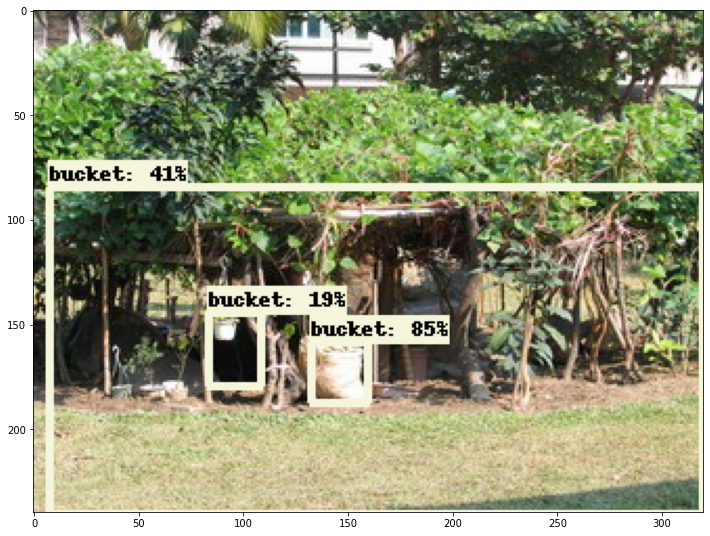

In [ ]:
label_id_offset = 1
image_np_with_detections = image_np.copy()
# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in detections:
  keypoints = detections['detection_keypoints'][0].numpy()
  keypoint_scores = detections['detection_keypoint_scores'][0].numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=number,
      min_score_thresh=.01,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=get_keypoint_tuples(configs['eval_config']))

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

# Part 3: 執行測試集的物件偵測

## Step 1: 執行偵測

In [ ]:
import os
import glob
import pandas as pd
Threshold = 0.3
classname = ['Nan', 'aquarium', 'bottle', 'bowl', 'box', 'bucket', 'plastic_bag', 
             'plate', 'styrofoam', 'tire', 'toilet', 'tub', 'washing_machine',
             'water_tower']
label_id_offset = 1
files = sorted(glob.glob('data/test_cdc/test_images/*.jpg'))
blist = []
for img_file in files:
  fname = os.path.basename(img_file)
  print(f"file:{fname} ", end="")
  image_np = load_image_into_numpy_array(img_file)
  width  = image_np.shape[1]
  height = image_np.shape[0]


  input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
  detections, predictions_dict, shapes = detect_fn(input_tensor)

  scores  =detections['detection_scores'][0].numpy()
  label_ids=detections['detection_classes'][0].numpy().astype(int) + label_id_offset
  boxes    =detections['detection_boxes'][0].numpy()

  bcount = 0;
  for score in list(scores):
    if score < Threshold:
      break
    bcount += 1
  if bcount==0 and scores[0] >0.2:
    bcount = 1
  print(f" count={bcount}")
  
  for i in range(bcount):
    score = scores[i]
    label_id = label_ids[i].astype(int)
    label_name = classname[label_id]
    box = boxes[i]
    xmin = round(box[0]*width)
    xmax = round(box[2]*width)
    ymin = round(box[1]*height)
    ymax = round(box[3]*height)
    record = (fname, label_id, xmin, ymin, xmax-xmin, ymax-ymin, score)
    blist.append(record)


file:200801213.jpg  count=2
file:200801216.jpg  count=1
file:200801221.jpg  count=1
file:20080123.jpg  count=1
file:200801241.jpg  count=3
file:200803144.jpg  count=0
file:20080319.jpg  count=1
file:200804281.jpg  count=0
file:200804303.jpg  count=1
file:2008043043.jpg  count=4
file:20080508.jpg  count=1
file:200805203.jpg  count=3
file:20080718.jpg  count=1
file:200807182.jpg  count=3
file:200807187.jpg  count=1
file:20080725.jpg  count=1
file:2008072511.jpg  count=1
file:200807253.jpg  count=1
file:200807254.jpg  count=1
file:200807256.jpg  count=1
file:200807259.jpg  count=0
file:20080811.jpg  count=3
file:20080821.jpg  count=0
file:200808212.jpg  count=0
file:200808213.jpg  count=1
file:200808214.jpg  count=0
file:200808215.jpg  count=2
file:200808218.jpg  count=1
file:2008082610.jpg  count=0
file:200808263.jpg  count=6
file:200808264.jpg  count=9
file:200808265.jpg  count=1
file:200808266.jpg  count=1
file:200808267.jpg  count=1
file:200808269.jpg  count=0
file:200809012.jpg  coun

 count=0
file:2009070215.jpg WARNING:tensorflow:6 out of the last 68 calls to <function get_model_detection_function.<locals>.detect_fn at 0x7f77e80249e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


 count=1
file:2009070217.jpg  count=1
file:2009070218.jpg  count=1
file:2009070219.jpg  count=1
file:2009070220.jpg  count=0
file:2009070223.jpg  count=1
file:2009070225.jpg  count=1
file:2009070226.jpg  count=1
file:2009070229.jpg  count=1
file:2009070233.jpg  count=1
file:2009070236.jpg  count=3
file:200907029.jpg  count=2
file:20090703102.jpg  count=0
file:2009070318.jpg  count=6
file:2009070322.jpg  count=7
file:2009070340.jpg  count=2
file:2009070354.jpg  count=5
file:2009070357.jpg  count=1
file:2009070358.jpg  count=1
file:2009070361.jpg  count=1
file:2009070366.jpg  count=2
file:2009070375.jpg  count=3
file:2009070380.jpg  count=0
file:2009070382.jpg  count=2
file:2009070386.jpg  count=10
file:2009070387.jpg  count=1
file:200907039.jpg  count=2
file:2009070394.jpg  count=1
file:20090706.jpg  count=3
file:20090707.jpg  count=0
file:200907072.jpg  count=1
file:200907073.jpg  count=1
file:200907075.jpg  count=1
file:200907081.jpg  count=0
file:200907082.jpg  count=0
file:200907083

## Step 2: 匯出測試集的預測結果

In [ ]:
column_name = ['image_filename', 'label_id', 'x', 'y', 'w', 'h', 'confidence']
df = pd.DataFrame(blist, columns=column_name)
df.to_csv(('mbsh/test_labels_hat2.csv'), index=None)